In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import time as time

In [2]:
# load hairpin data
data_path = '../../../data_toyhairpin/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}



In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    
    layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                        # concat, embedding, variational_normal, variational_softmax, + more
              'num_units': 8,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.5,           # if removed, default is no dropout
             }
    
    layer3 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/toyhairpin'
param_path = os.path.join(save_path, 'fullyconnected_1_8')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: dense_0
(?, 8)
layer3: dense_0_batch
(?, 8)
layer4: dense_0_active
(?, 8)
layer5: dense_0_dropout
(?, 8)
layer6: dense_1
(?, 1)
layer7: dense_1_bias
(?, 1)
layer8: output
(?, 1)
----------------------------------------------------------------------------


In [4]:
# initialize session
sess = utils.initialize_session()

In [5]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=30, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=4.91s -- loss=0.52217 -- acc=66.426563%  
 
  valid loss:		0.22263
  valid accuracy:	0.99758+/-0.00000
  valid auc-roc:	0.99963+/-0.00000
  valid auc-pr:		0.99897+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/toyhairpin/fullyconnected_1_8_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=4.78s -- loss=0.36099 -- acc=80.126563%  
 
  valid loss:		0.16467
  valid accuracy:	0.99856+/-0.00000
  valid auc-roc:	0.99976+/-0.00000
  valid auc-pr:		0.99942+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/toyhairpin/fullyconnected_1_8_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=4.90s -- loss=0.34130 -- acc=81.171877%  
 
  valid loss:		0.13865
  valid accuracy:	0.99821+/-0.00000
  valid auc-roc:	0.99976+/-0.00000
  valid auc-pr:		0.99941+/-0.00000
  lower cross-validation found
  savi

In [6]:
sess.close()
sess = utils.initialize_session()

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/toyhairpin/fullyconnected_1_8_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/fullyconnected_1_8_best.ckpt
  test  loss:		0.12082
  test  accuracy:	0.99887+/-0.00000
  test  auc-roc:	0.99972+/-0.00000
  test  auc-pr:		0.99914+/-0.00000


## First order mutagenesis saliency

In [8]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

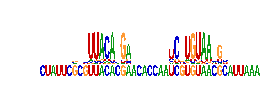

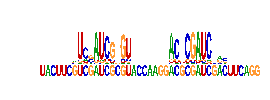

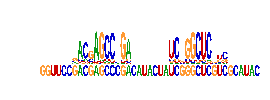

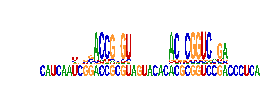

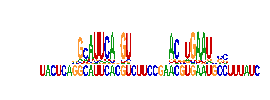

In [20]:
numplots=5

for ii in range(numplots): 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    mf.fom_saliency(X, layer='output', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))
    

## Second Order Mutagenesis 

In [10]:
savepath = 'Arrays/toyhairpin_FC_1_8_sumoutputs1k.npy'

num_summary = 1000
X = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average(X, savepath, nntrainer, sess, progress='off')

----------------Summing complete----------------
Saving scores to Arrays/toyhairpin_FC_1_8_sumoutputs1k.npy


In [11]:
#Load the saved data
savepath = 'Arrays/toyhairpin_FC_1_8_sumoutputs1k.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 1000
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
meanhol_mut2 = mean_mut2.reshape(X.shape[1],X.shape[1],4,4)

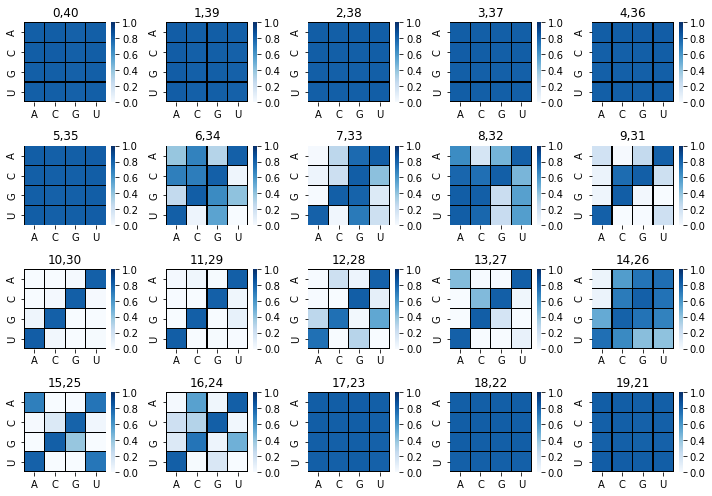

In [12]:
mf.symlinear_holplot(meanhol_mut2, figplot=(4,5), alphabet='rna')

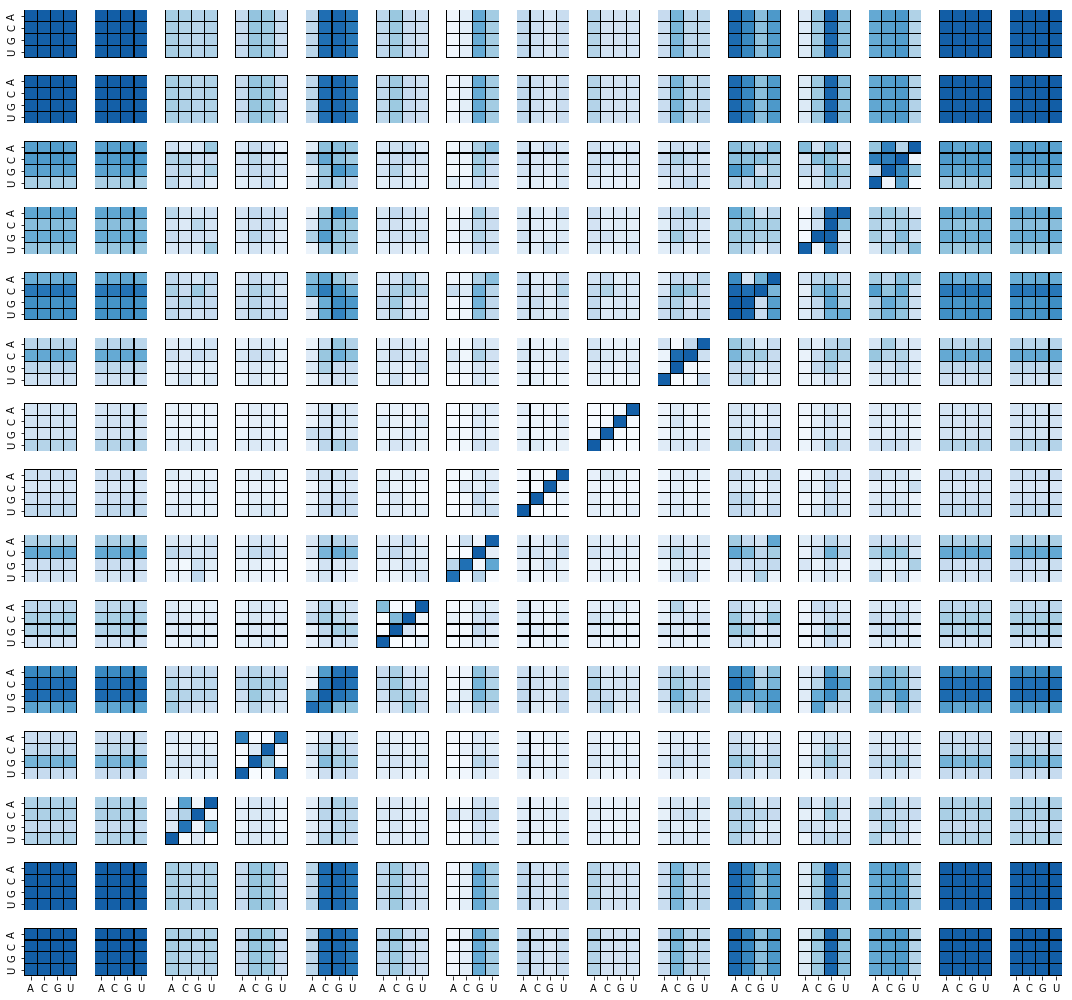

In [13]:
mf.square_holplot(meanhol_mut2, num=15, alphabet='rna')

## Look at Hidden Layers

In [14]:
W = nnmodel.get_parameters(sess, layer='dense_1')[0]
top_neurons=np.argsort(np.squeeze(W))[::-1]
top_neurons

array([6, 0, 7, 4, 1, 5, 2, 3])

In [15]:
top_weights=np.sort(np.squeeze(W))[::-1]
top_weights

array([ 0.9895722,  0.8487142,  0.6894215, -3.3191054, -3.3996234,
       -3.534822 , -3.5944262, -3.8194234], dtype=float32)

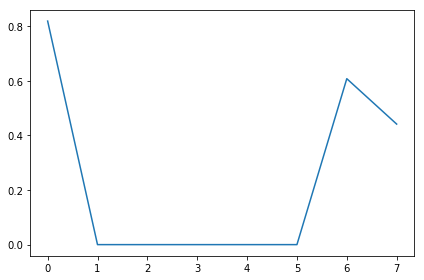

' An example of how a single sequence can excite various different neurons'

In [16]:
dense = nntrainer.get_activations(sess, test, layer='dense_0_active')

#plot which neurons got activated by the highest predicted sequence (from the outputs)
plt.plot(range(dense.shape[1]), dense[plot_index[0]])
plt.show()

''' An example of how a single sequence can excite various different neurons'''



## Look at the dense parameters

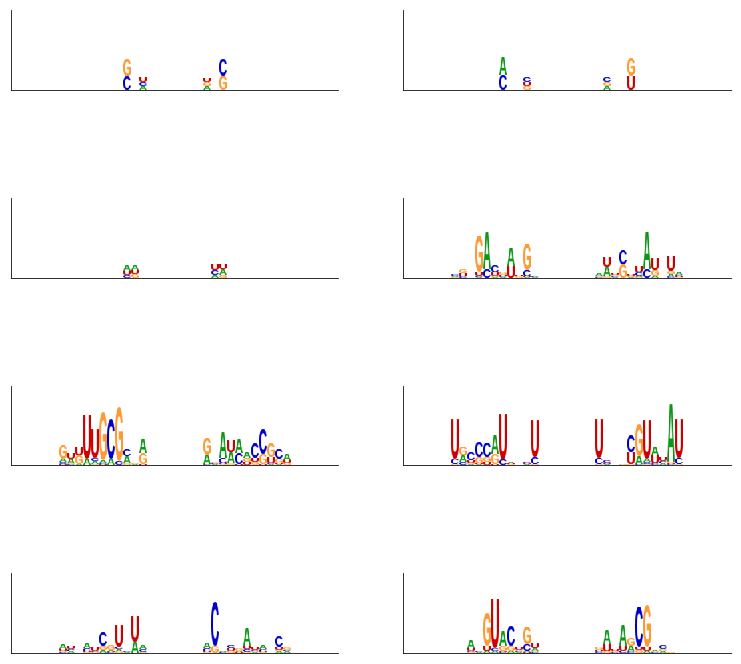

In [19]:
W = nnmodel.get_parameters(sess, layer='dense_0')[0]
W = W.reshape((41,4,dense.shape[1]))
W = np.expand_dims(W, axis=1)

num_plots = 8

Wplot = W[:,:,:,top_neurons[:num_plots]]

fig = visualize.plot_filter_logos(Wplot, figsize=(100,100), height=50,
                                 nt_width=10, norm=0, alphabet='rna', num_rows=num_plots//2)



## Second order mutagenesis based on the neuron outputs

In [29]:
neuron = top_neurons[1]
top_indices = np.argsort(dense[:,neuron])[::-1]

num_summary = 500

X = test['inputs'][top_indices[:num_summary]]
savepath = 'Arrays/toyhairpin_FC_1_8_sumneuron0_500.npy'

sum_mut2 = mf.som_neruonaverage(X,'dense_0_active', neuron, savepath, nntrainer, sess, progress='off')

----------------Summing complete----------------
Saving scores to Arrays/toyhairpin_FC_1_8_sumneuron0_500.npy


In [30]:
#Load the saved data
savepath = 'Arrays/toyhairpin_FC_1_8_sumneuron0_500.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 500
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
meanhol_mut2 = mean_mut2.reshape(X.shape[1],X.shape[1],4,4)

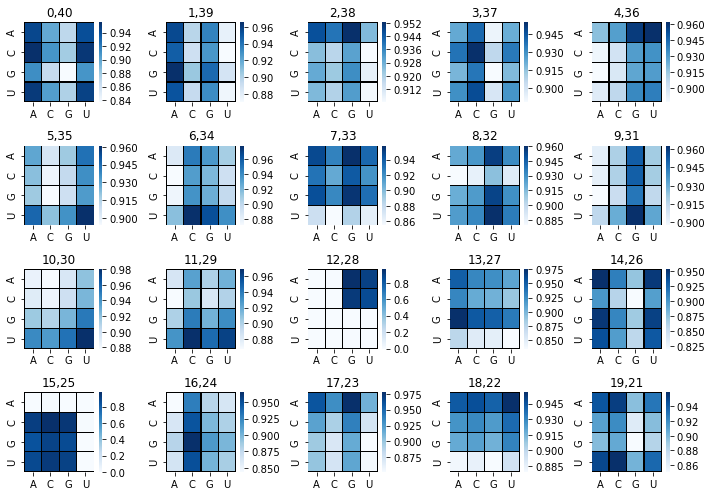

In [31]:
mf.symlinear_holplot(meanhol_mut2, figplot=(4,5), alphabet='rna', limits=False)

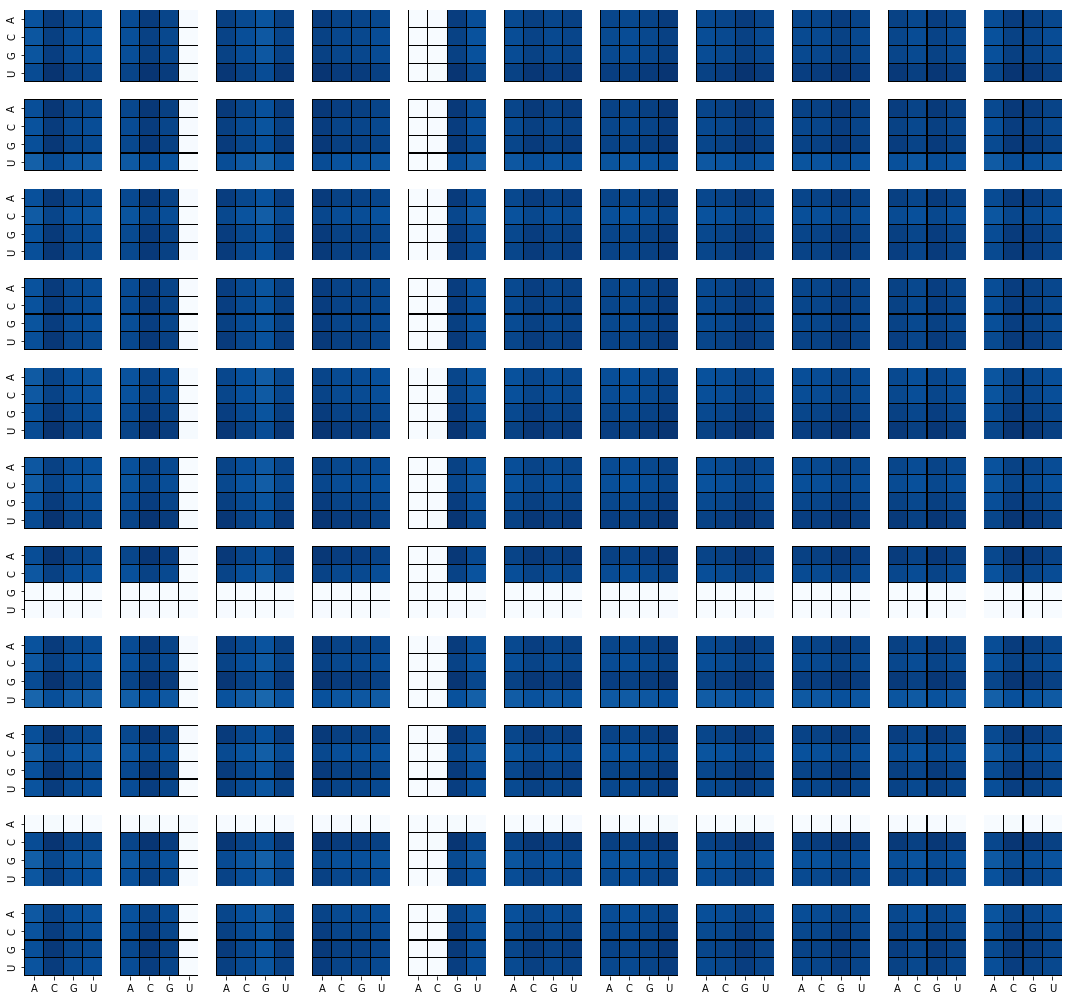

In [32]:
mf.square_holplot(meanhol_mut2, num=11, alphabet='rna', figsize=(7,6), start=(6,24))